In [1]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
import tree_math as tm
from src.sampling.exact_ggn import exact_ggn_laplace
from src.sampling.laplace_ode import ode_ggn

In [6]:
def f(x):
    return jnp.sin(5 * x + 1) #+ jnp.cos(25 * x + 1) + jnp.exp(0.1 * x) + 5


In [7]:
param_dict = pickle.load(open("../checkpoints/syntetic_regression.pickle", "rb"))
params = param_dict['params']
alpha = param_dict['alpha']
rho = param_dict['rho']
x_train, y_train, x_val, y_val, model, D = param_dict["train_stats"]['x_train'],param_dict["train_stats"]['y_train'],param_dict["train_stats"]['x_val'],param_dict["train_stats"]['y_val'],param_dict["train_stats"]['model'], param_dict["train_stats"]['n_params']

In [8]:
sample_key = jax.random.PRNGKey(100)
model_fn = lambda params, x: model.apply(params, x[None, ...])[0]
n_params = D 
rank = 3
alpha = 1.0
n_posterior_samples = 200
var = 0.1

lr_posterior_samples, posterior_samples, isotropic_posterior_samples = exact_ggn_laplace(sse_loss, 
                                                                                         model_fn,
                                                                                         params,
                                                                                         x_train,
                                                                                         y_train,
                                                                                         n_params,
                                                                                         rank,
                                                                                         alpha,
                                                                                         n_posterior_samples,
                                                                                         sample_key,
                                                                                         var,
                                                                                         "all"
                                                                                         )

## Sampled Laplace

In [9]:
predictive = sample_predictive(lr_posterior_samples, params, model, x_val, False, "Pytree")
# predictive = sample_hessian_predictive(posterior_samples, model.apply, params, x_val)

In [10]:
posterior_predictive_mean = jnp.mean(predictive, axis=0).squeeze()
posterior_predictive_std = jnp.std(predictive, axis=0).squeeze()
preds = model.apply(params, x_val)
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
means_sorted = posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
std_sorted = posterior_predictive_std[idx]


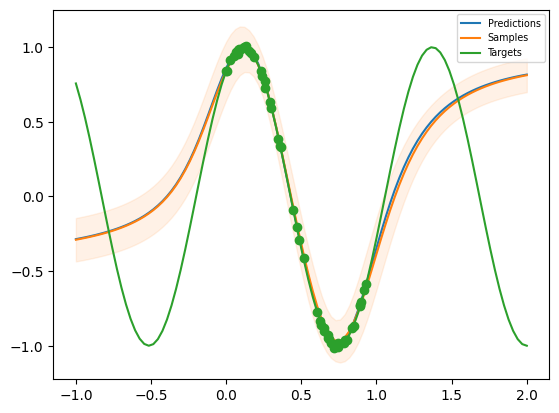

In [11]:
plt.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = plt.plot(x_sorted, means_sorted, label="Samples", marker="None")
plt.fill_between(
    x_sorted, means_sorted - std_sorted, means_sorted + std_sorted, alpha=0.1, color=line[0].get_color()
)
line = plt.plot(x_sorted, f(x_sorted), label="Targets", marker="None")
plt.plot(
    jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
)
plt.legend(fontsize="x-small", loc="upper right")

plt.show()

## Laplace Diffusion

### Proj VP

In [40]:
output_dim = 1
def nonker_proj_vp(v, model_fn, params, X):
    lmbd = lambda p: model_fn(p, X)
    _, jtv_fn = jax.vjp(lmbd, params)
    def kvp(v_):
        _, jtv_fn = jax.vjp(lmbd, params)
        Jtv = jtv_fn(v_.reshape((X.shape[0],output_dim)))[0]
        _, JJtv = jax.jvp(lmbd, (params,), (Jtv,))
        return JJtv
    JJt = jax.jacfwd(kvp)(jnp.ones((X.shape[0], output_dim,)))
    JJt = JJt.reshape(X.shape[0] * output_dim, X.shape[0] * output_dim)
    _, Jv = jax.jvp(lmbd, (params,), (v,))
    JJt_inv_Jv = jnp.linalg.lstsq(JJt, Jv.reshape(-1))[0]
    _, jtv_fn = jax.vjp(lmbd, params)
    JJt_inv_Jv = JJt_inv_Jv.reshape((X.shape[0],output_dim))
    Jt_JJt_inv_Jv = jtv_fn(JJt_inv_Jv)[0]
    return Jt_JJt_inv_Jv

def ker_proj_vp(v, model_fn, params, X):
    lmbd = lambda p: model_fn(p, X)
    _, jtv_fn = jax.vjp(lmbd, params)
    def kvp(v_):
        _, jtv_fn = jax.vjp(lmbd, params)
        Jtv = jtv_fn(v_.reshape((X.shape[0],output_dim)))[0]
        _, JJtv = jax.jvp(lmbd, (params,), (Jtv,))
        return JJtv
    JJt = jax.jacfwd(kvp)(jnp.ones((X.shape[0], output_dim,)))
    JJt = JJt.reshape(X.shape[0] * output_dim, X.shape[0] * output_dim)
    _, Jv = jax.jvp(lmbd, (params,), (v,))
    JJt_inv_Jv = jnp.linalg.lstsq(JJt, Jv.reshape(-1))[0]
    _, jtv_fn = jax.vjp(lmbd, params)
    JJt_inv_Jv = JJt_inv_Jv.reshape((X.shape[0],output_dim))
    Jt_JJt_inv_Jv = jtv_fn(JJt_inv_Jv)[0]
    return (tm.Vector(v) - tm.Vector(Jt_JJt_inv_Jv)).tree

In [47]:
n_steps = 1000
n_samples = 50
eps = tree_random_normal_like(sample_key, params, n_samples)
alpha = 100.0
rank = 7
p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)
# rank = 100
# alpha = 0.1
key_list = jax.random.split(jax.random.PRNGKey(10), n_steps)
key = jax.random.PRNGKey(10)
@jax.jit
def rw_nonker(key):
    params_ = params
    sample_key, split_key = jax.random.split(key)
    eps = tree_random_normal_like(sample_key, params, n_samples)
    # posterior_list = [params]
    def body_fun(n, res):
        # split_key = key_list[n]
        # sample_key, split_key = jax.random.split(split_key)
        sample_key = key_list[n]
        eps = tree_random_normal_like(sample_key, params, n_samples)
        lr_samples = jax.vmap(nonker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
        params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, res, lr_samples)
        # posterior_list.append(params_)
        return params_
    v_ = jax.lax.fori_loop(0, n_steps - 1, body_fun, jax.tree_map(lambda x: jnp.array(n_samples*[x]), params))
    return v_
nonker_posterior_samples = rw_nonker(key)

#     for i in range(n_steps):
#         sample_key, split_key = jax.random.split(split_key)
#         eps = tree_random_normal_like(sample_key, params, n_samples)
#         lr_samples = jax.vmap(nonker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
#         params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, params_, lr_samples)
#         posterior_list.append(params_)
#     return posterior_list
#     # return unravel_func_p(params_)

# nonker_posterior_samples = rw_nonker(key)[-1]#jax.vmap(rw_nonker)(eps)[-1]#jax.lax.map(rw, eps)

In [48]:
n_steps = 1000
n_samples = 50
eps = tree_random_normal_like(sample_key, params, n_samples)
alpha = 100.0
rank = 7
p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)
# rank = 100
# alpha = 0.1
key_list = jax.random.split(jax.random.PRNGKey(10), n_steps)
key = jax.random.PRNGKey(10)
@jax.jit
def rw_ker(key):
    params_ = params
    sample_key, split_key = jax.random.split(key)
    eps = tree_random_normal_like(sample_key, params, n_samples)
    # posterior_list = [params]
    def body_fun(n, res):
        # split_key = key_list[n]
        # sample_key, split_key = jax.random.split(split_key)
        sample_key = key_list[n]
        eps = tree_random_normal_like(sample_key, params, n_samples)
        lr_samples = jax.vmap(ker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
        params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, res, lr_samples)
        # posterior_list.append(params_)
        return params_
    v_ = jax.lax.fori_loop(0, n_steps - 1, body_fun, jax.tree_map(lambda x: jnp.array(n_samples*[x]), params))
    return v_
ker_posterior_samples = rw_ker(key)


In [49]:
# n_steps = 20
# n_samples = 50
# eps = tree_random_normal_like(sample_key, params, n_samples)
# alpha = 10.0
# rank = 7
# p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)
# # rank = 100
# # alpha = 0.1
# key = jax.random.PRNGKey(10)

# @jax.jit
# def rw_ker(key):
#     params_ = params
#     sample_key, split_key = jax.random.split(key)
#     eps = tree_random_normal_like(sample_key, params, n_samples)
#     posterior_list = [params]
#     for i in range(n_steps):
#         sample_key, split_key = jax.random.split(split_key)
#         eps = tree_random_normal_like(sample_key, params, n_samples)
#         lr_samples = jax.vmap(ker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
#         params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, params_, lr_samples)
#         posterior_list.append(params_)
#     return posterior_list
#     # return unravel_func_p(params_)

# ker_posterior_samples = rw_ker(key)[-1]#jax.vmap(rw_ker, in_axes=(0))(eps)[-1]#jax.lax.map(rw, eps)

In [50]:
x_val = x_train
preds = model.apply(params, x_val)

ker_predictive = sample_predictive(ker_posterior_samples, params, model, x_val, False, "Pytree")
# ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0)
# ker_predictive = ker_predictive + preds - ker_posterior_predictive_mean
nonker_predictive = sample_predictive(nonker_posterior_samples, params, model, x_val, False, "Pytree")
ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0).squeeze()
ker_posterior_predictive_std = jnp.std(ker_predictive, axis=0).squeeze()
nonker_posterior_predictive_mean = jnp.mean(nonker_predictive, axis=0).squeeze()
nonker_posterior_predictive_std = jnp.std(nonker_predictive, axis=0).squeeze()


x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
ker_means_sorted = ker_posterior_predictive_mean[idx]
nonker_means_sorted = nonker_posterior_predictive_mean[idx]
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()
ker_std_sorted = ker_posterior_predictive_std[idx]
nonker_std_sorted = nonker_posterior_predictive_std[idx]



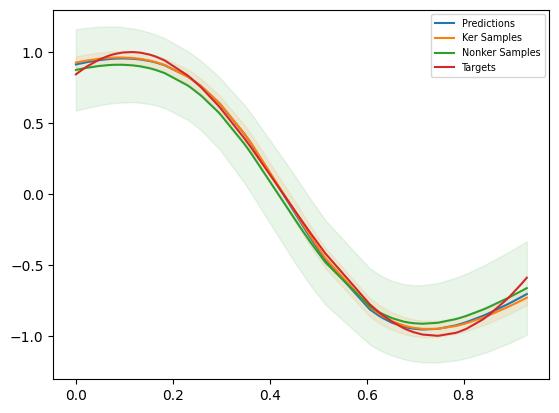

In [51]:
plt.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = plt.plot(x_sorted, ker_means_sorted, label="Ker Samples", marker="None")
plt.fill_between(
    x_sorted, ker_means_sorted - ker_std_sorted, ker_means_sorted + ker_std_sorted, alpha=0.1, color=line[0].get_color()
)
line = plt.plot(x_sorted, nonker_means_sorted, label="Nonker Samples", marker="None")
plt.fill_between(
    x_sorted, nonker_means_sorted - nonker_std_sorted, nonker_means_sorted + nonker_std_sorted, alpha=0.1, color=line[0].get_color()
)

line = plt.plot(x_sorted, f(x_sorted), label="Targets", marker="None")
# plt.plot(
#     jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
# )
plt.legend(fontsize="x-small", loc="upper right")

plt.show()

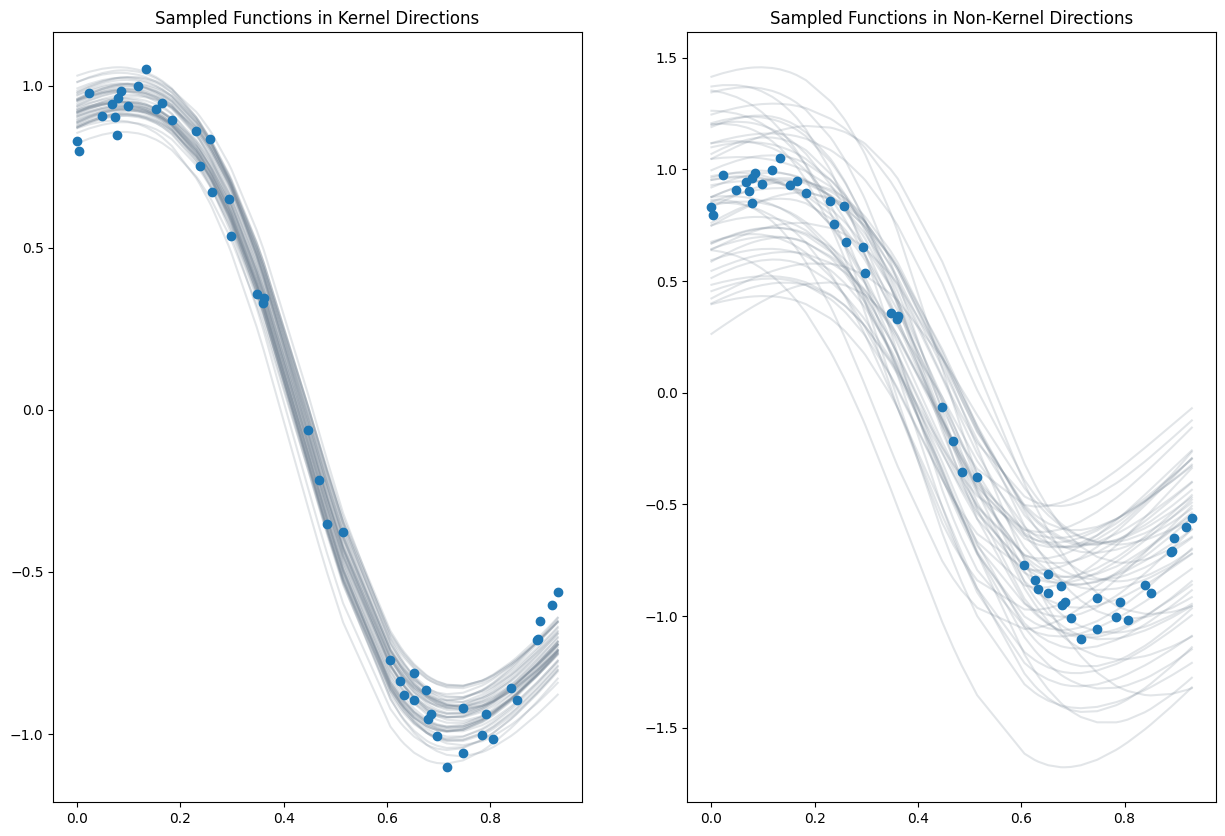

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("Sampled Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("Sampled Functions in Non-Kernel Directions")
plt.show()

### Explicit Matrix Computations

In [8]:
from src.sampling.exact_ggn_diffusion import exact_nonkernel_diffusion, exact_kernel_diffusion

In [9]:
_model_fn = lambda params, x: model.apply(params, x[None, ...])[0]

In [91]:
n_steps = 200
n_samples = 50
# alpha = 5.0
alpha = 10.0
rank = 7
sample_key = jax.random.PRNGKey(0)
nonker_posterior_samples = exact_nonkernel_diffusion(sse_loss, _model_fn, params, n_steps, n_samples,alpha, sample_key, D, rank, x_train, y_train)

In [115]:
n_steps = 200
n_samples = 50
# alpha = 5.0
alpha = 10.0
rank = 20
sample_key = jax.random.PRNGKey(0)
ker_posterior_samples = exact_kernel_diffusion(sse_loss, _model_fn, params, n_steps, n_samples,alpha, sample_key, D, rank, x_train, y_train)

In [125]:
jnp.std(ker_posterior_samples['params']['Dense_2']['bias'])

Array(0.15721473, dtype=float32)

In [117]:
jnp.mean(jnp.array(n_samples*[params['params']['Dense_2']['bias']]))

Array(0.26397395, dtype=float32)

In [110]:
ker_posterior_samples['params']['Dense_2']['bias'] = jnp.array(n_samples*[params['params']['Dense_2']['bias']])

In [111]:
x_val = x_train
ker_predictive = sample_predictive(ker_posterior_samples, params, model, x_val, False, "Pytree")
nonker_predictive = sample_predictive(nonker_posterior_samples, params, model, x_val, False, "Pytree")
ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0).squeeze()
ker_posterior_predictive_std = jnp.std(ker_predictive, axis=0).squeeze()
nonker_posterior_predictive_mean = jnp.mean(nonker_predictive, axis=0).squeeze()
nonker_posterior_predictive_std = jnp.std(nonker_predictive, axis=0).squeeze()
preds = model.apply(params, x_val)


x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
ker_means_sorted = ker_posterior_predictive_mean[idx]
nonker_means_sorted = nonker_posterior_predictive_mean[idx]
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()
ker_std_sorted = ker_posterior_predictive_std[idx]
nonker_std_sorted = nonker_posterior_predictive_std[idx]



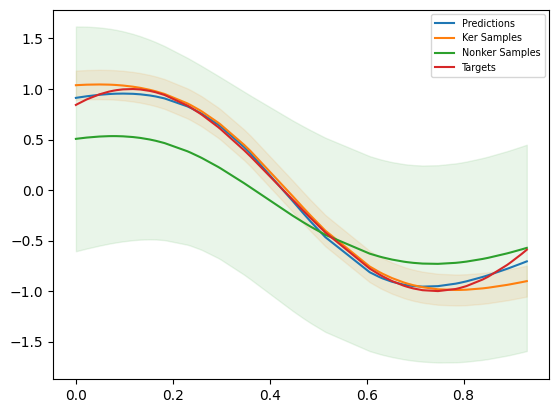

In [112]:
plt.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = plt.plot(x_sorted, ker_means_sorted, label="Ker Samples", marker="None")
plt.fill_between(
    x_sorted, ker_means_sorted - ker_std_sorted, ker_means_sorted + ker_std_sorted, alpha=0.1, color=line[0].get_color()
)
line = plt.plot(x_sorted, nonker_means_sorted, label="Nonker Samples", marker="None")
plt.fill_between(
    x_sorted, nonker_means_sorted - nonker_std_sorted, nonker_means_sorted + nonker_std_sorted, alpha=0.1, color=line[0].get_color()
)

line = plt.plot(x_sorted, f(x_sorted), label="Targets", marker="None")
# plt.plot(
#     jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
# )
plt.legend(fontsize="x-small", loc="upper right")

plt.show()

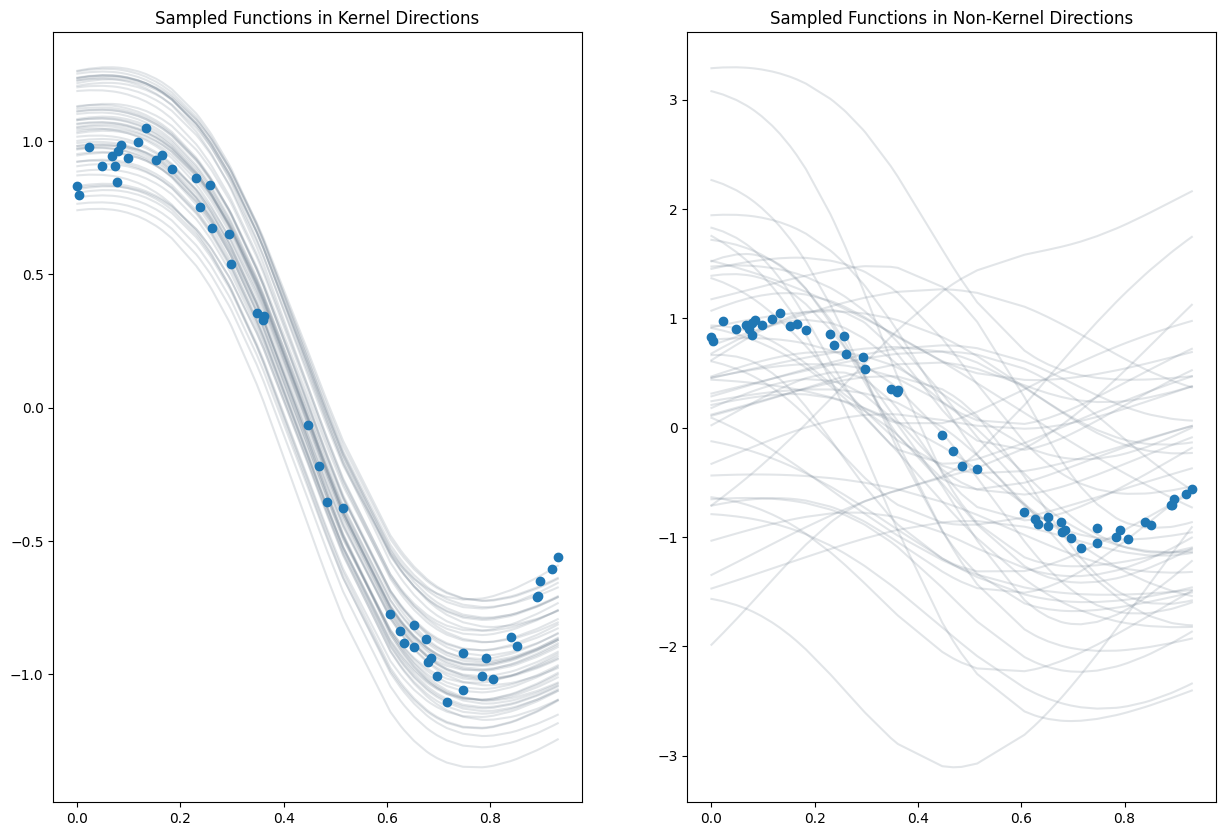

In [113]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("Sampled Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("Sampled Functions in Non-Kernel Directions")
plt.show()

## Lanczos Diffusion

In [8]:
sample_key = jax.random.PRNGKey(50)

In [9]:
from src.sampling.lanczos_diffusion import lanczos_diffusion
n_steps = 2000
n_samples = 50
alpha = 20.0
rank = 7
n_params = D
# nonker_posterior_samples = lanczos_diffusion(sse_loss, model.apply, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,y_train,1.0,"non-kernel")
nonker_posterior_samples = lanczos_diffusion(model, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,"regression",1.0,"non-kernel")

In [10]:
rank = 7

# ker_posterior_samples = lanczos_diffusion(sse_loss, model.apply, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,y_train,1.0,"kernel")
ker_posterior_samples = lanczos_diffusion(model, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,"regression",1.0,"kernel")

In [11]:
# x_val = x_train
x_val = jnp.linspace(-1,2,100).reshape(-1,1)
ker_predictive = sample_predictive(ker_posterior_samples, params, model, x_val, False, "Pytree")
nonker_predictive = sample_predictive(nonker_posterior_samples, params, model, x_val, False, "Pytree")
ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0).squeeze()
ker_posterior_predictive_std = jnp.std(ker_predictive, axis=0).squeeze()
nonker_posterior_predictive_mean = jnp.mean(nonker_predictive, axis=0).squeeze()
nonker_posterior_predictive_std = jnp.std(nonker_predictive, axis=0).squeeze()
preds = model.apply(params, x_val)


x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
ker_means_sorted = ker_posterior_predictive_mean[idx]
nonker_means_sorted = nonker_posterior_predictive_mean[idx]
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()
ker_std_sorted = ker_posterior_predictive_std[idx]
nonker_std_sorted = nonker_posterior_predictive_std[idx]



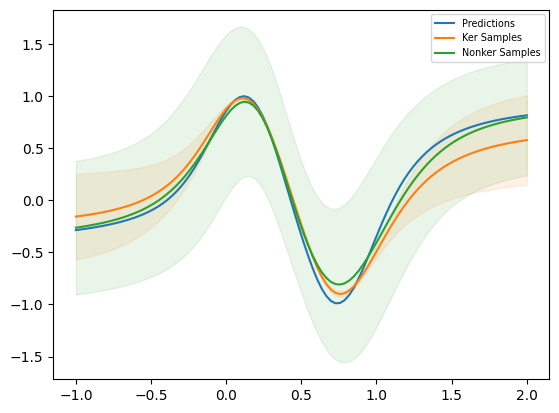

In [12]:
plt.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = plt.plot(x_sorted, ker_means_sorted, label="Ker Samples", marker="None")
plt.fill_between(
    x_sorted, ker_means_sorted - ker_std_sorted, ker_means_sorted + ker_std_sorted, alpha=0.1, color=line[0].get_color()
)
line = plt.plot(x_sorted, nonker_means_sorted, label="Nonker Samples", marker="None")
plt.fill_between(
    x_sorted, nonker_means_sorted - nonker_std_sorted, nonker_means_sorted + nonker_std_sorted, alpha=0.1, color=line[0].get_color()
)

# line = plt.plot(x_sorted, f(x_sorted), label="Targets", marker="None")
# plt.plot(
#     jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
# )
plt.legend(fontsize="x-small", loc="upper right")

plt.show()

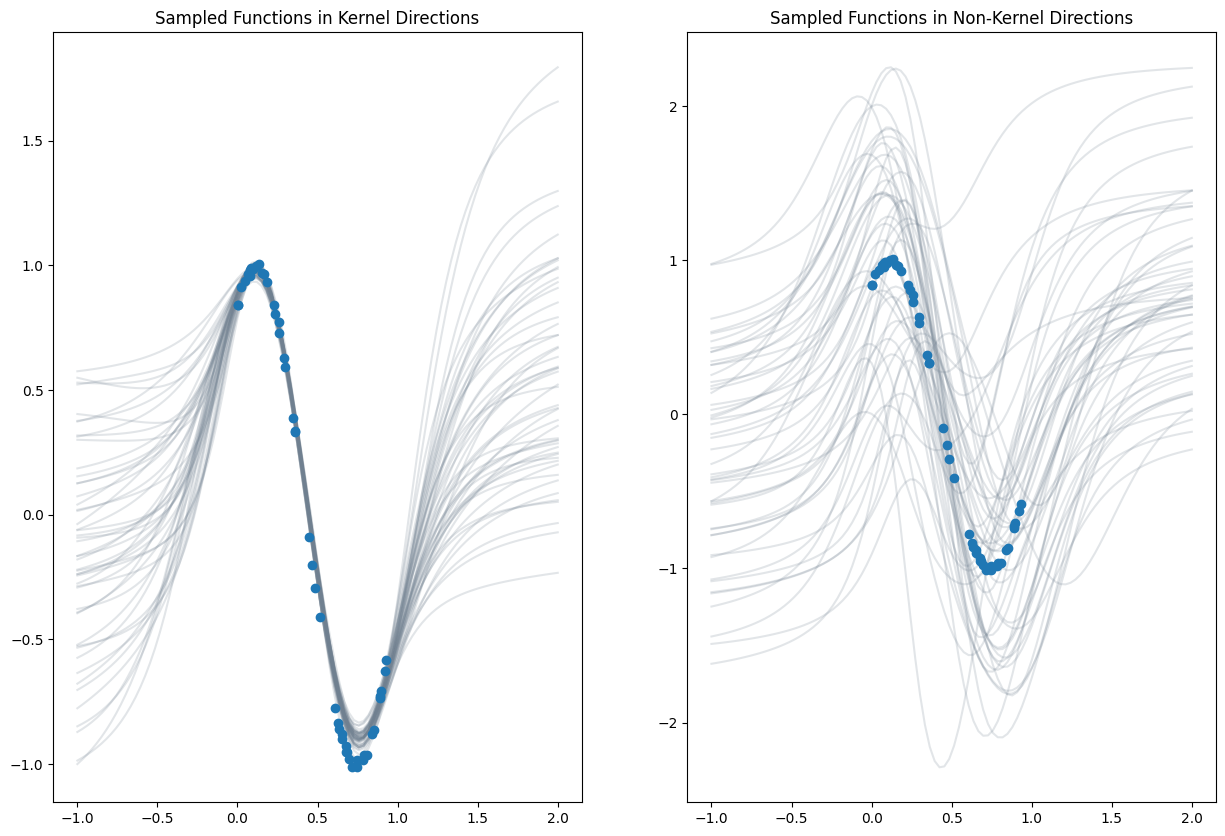

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("Sampled Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("Sampled Functions in Non-Kernel Directions")
plt.show()

## ODE Solver

### Kernel ODE

In [12]:
random_init_dir = jax.random.normal(sample_key, (D,))
v0 = jnp.ones(D)*5
n_evals = 10
integration_time = 1.0
rank = 7
ker_posterior, y_sols = ode_ggn(model,params,random_init_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-8, 1e-8,1.0,"kernel")


In [13]:
predictive = sample_predictive(ker_posterior, params, model, x_train, False, "Pytree")
posterior_predictive_mean = jnp.mean(predictive, axis=0).squeeze()
posterior_predictive_std = jnp.std(predictive, axis=0).squeeze()
preds = model.apply(params, x_train)
x_sorted, idx = jnp.sort(x_train[:, 0]), jnp.argsort(x_train[:, 0])
preds_sorted = preds[idx][:, 0]
means_sorted = posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
std_sorted = posterior_predictive_std[idx]


In [14]:
if n_evals==1:
    samples_sorted = jnp.expand_dims(samples_sorted, 0)

In [15]:
p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)

euclidean_distances = []
for param in y_sols:
    euclidean_distances.append(jnp.linalg.norm(param - p0_flat))
fn_space_distances = []
for fn in samples_sorted:
    fn_space_distances.append(jnp.linalg.norm(fn.squeeze() - preds_sorted))
    # fn_space_distances.append(jnp.linalg.norm(fn - preds_sorted))

In [16]:
fn_space_distances

[Array(0., dtype=float32),
 Array(0.09554042, dtype=float32),
 Array(0.17776747, dtype=float32),
 Array(0.19536512, dtype=float32),
 Array(0.21314524, dtype=float32),
 Array(0.20473512, dtype=float32),
 Array(0.20033933, dtype=float32),
 Array(0.19779915, dtype=float32),
 Array(0.20252359, dtype=float32),
 Array(0.20769458, dtype=float32)]

In [17]:
euclidean_distances

[Array(0., dtype=float32),
 Array(1.1992722, dtype=float32),
 Array(2.403725, dtype=float32),
 Array(3.5757995, dtype=float32),
 Array(4.749887, dtype=float32),
 Array(5.91925, dtype=float32),
 Array(7.1021705, dtype=float32),
 Array(8.301478, dtype=float32),
 Array(9.504068, dtype=float32),
 Array(10.687618, dtype=float32)]

Text(0.5, 0, 'Euclidean Distance')

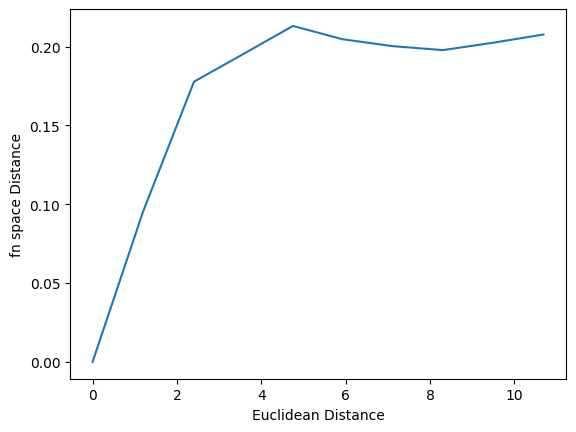

In [18]:
plt.plot(jnp.array(euclidean_distances), jnp.array(fn_space_distances))
plt.ylabel("fn space Distance")
plt.xlabel("Euclidean Distance")

Text(0.5, 1.0, 'Ode solutions')

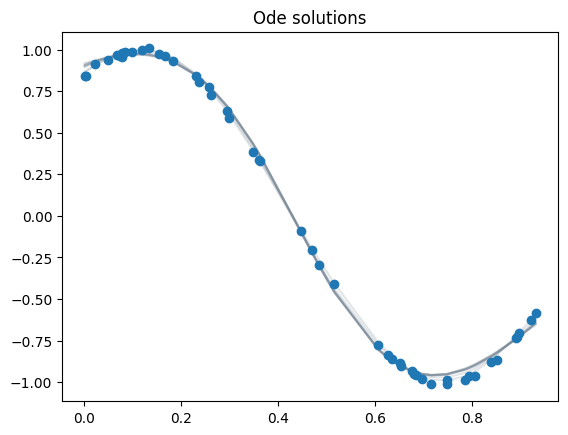

In [15]:
plt.plot(x_sorted, samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
plt.plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
plt.title("Ode solutions")

### Non-Kernel ODE

In [16]:
random_init_dir = jax.random.normal(sample_key, (D,))
v0 = jnp.ones(D)*5
n_evals = 10
integration_time = 1.0
rank = 7
nonker_posterior, y_sols = ode_ggn(model,params,random_init_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-7, 1e-7,1.0,"non-kernel")


In [17]:
predictive = sample_predictive(nonker_posterior, params, model, x_train, False, "Pytree")
posterior_predictive_mean = jnp.mean(predictive, axis=0).squeeze()
posterior_predictive_std = jnp.std(predictive, axis=0).squeeze()
preds = model.apply(params, x_train)
x_sorted, idx = jnp.sort(x_train[:, 0]), jnp.argsort(x_train[:, 0])
preds_sorted = preds[idx][:, 0]
means_sorted = posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
std_sorted = posterior_predictive_std[idx]


In [18]:
euclidean_distances = []
for param in y_sols:
    euclidean_distances.append(jnp.linalg.norm(param - p0_flat))
fn_space_distances = []
for fn in samples_sorted:
    fn_space_distances.append(jnp.linalg.norm(fn.squeeze() - preds_sorted))

Text(0.5, 0, 'Euclidean Distance')

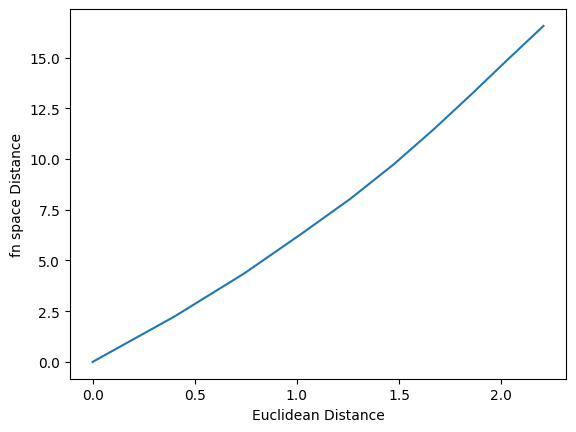

In [19]:
plt.plot(jnp.array(euclidean_distances), jnp.array(fn_space_distances))
plt.ylabel("fn space Distance")
plt.xlabel("Euclidean Distance")

Text(0.5, 1.0, 'Ode solutions')

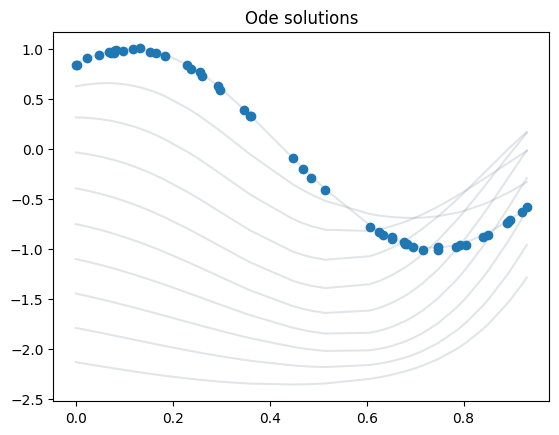

In [20]:
plt.plot(x_sorted, samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
plt.plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
plt.title("Ode solutions")

### Multiple directions

In [19]:
idx = jnp.concatenate([jnp.arange(5), jnp.arange(15,20), jnp.arange(45,50)])
x_train = x_train[idx]
y_train = y_train[idx]

In [20]:
n_dirs = 50
random_init_dir = jax.random.normal(sample_key, (n_dirs, D,))

def non_ker_ode_solve_multiple_dir(single_dir):
    n_evals = 2
    integration_time = 1.0
    rank = 7
    v0 = jnp.ones(D)*5
    nonker_posterior, y_sols = ode_ggn(model,params,single_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-7, 1e-7,1.0,"non-kernel")
    nonker_posterior = jax.tree_map(lambda x: x[-1], nonker_posterior)
    return nonker_posterior
    
# nonker_posterior = jax.vmap(non_ker_ode_solve_multiple_dir)(random_init_dir)
nonker_posterior = jax.lax.map(non_ker_ode_solve_multiple_dir, random_init_dir)


In [21]:
nonker_predictive = sample_predictive(nonker_posterior, params, model, x_val, False, "Pytree")
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()



In [22]:
n_dirs = 50
random_init_dir = jax.random.normal(sample_key, (n_dirs, D,))

def ker_ode_solve_multiple_dir(single_dir):
    n_evals = 2
    integration_time = 1.0
    rank = 7
    v0 = jnp.ones(D)*5
    ker_posterior, y_sols = ode_ggn(model,params,single_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-7, 1e-7,1.0,"kernel")
    ker_posterior = jax.tree_map(lambda x: x[-1], ker_posterior)
    return ker_posterior
    
# ker_posterior = jax.vmap(ker_ode_solve_multiple_dir)(random_init_dir)
ker_posterior = jax.lax.map(ker_ode_solve_multiple_dir, random_init_dir)


In [23]:
ker_predictive = sample_predictive(ker_posterior, params, model, x_val, False, "Pytree")
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()


[]

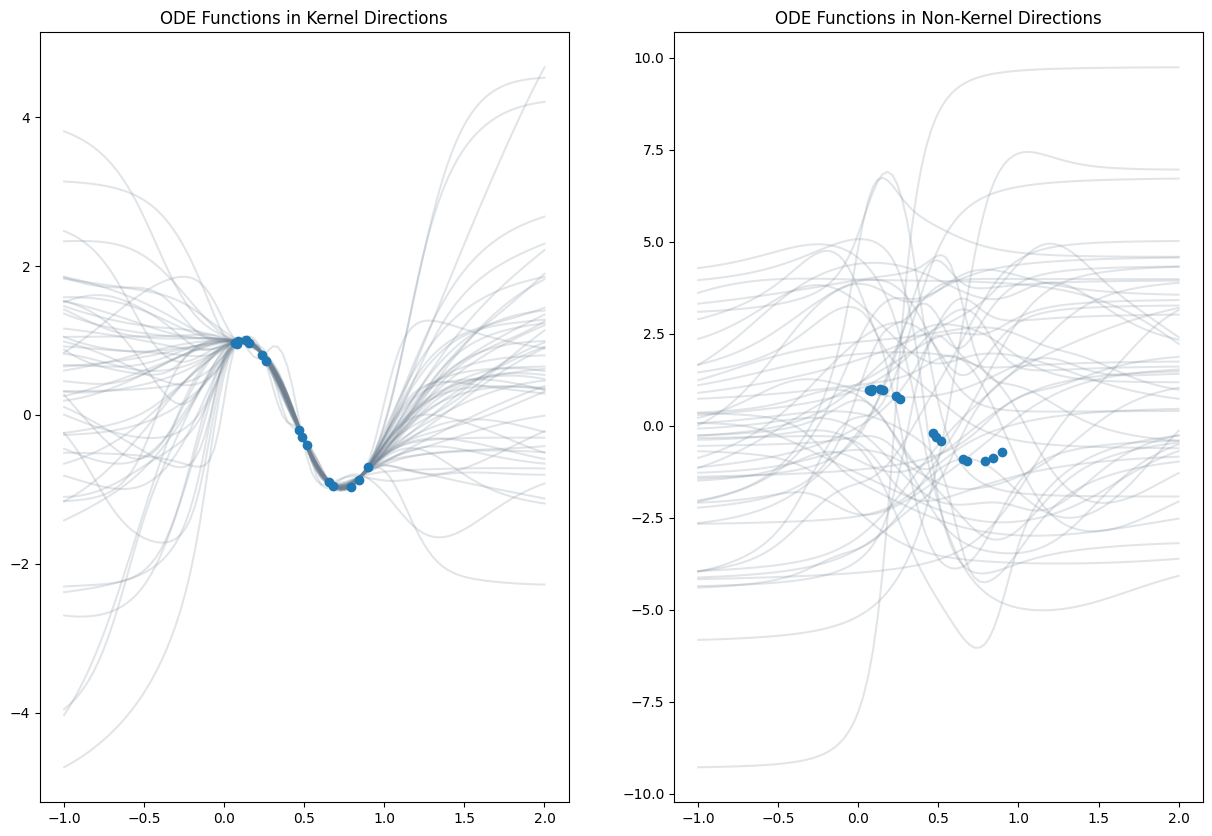

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("ODE Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("ODE Functions in Non-Kernel Directions")
plt.plot()